### imports ###

In [5]:
import mdtraj as md
import numpy as np 
import matplotlib.pyplot as plt
import os, sys
import matplotlib.colors as colors
import json
import scipy.stats
from scipy.stats import pearsonr
import importlib

In [8]:
def max_str(files):
    if isinstance(files,list):
        files = np.array(files)
    return files[np.argmax(np.array([num_str(f, return_str = False, return_num = True) for f in files]))]
def sort_strs(files, max = False):
    if isinstance(files,list):
        files = np.array(files)
    if max:
        return files[np.argsort(np.array([num_str(f, return_str = False, return_num = True) for f in files]))]
    else:
        return files[np.argsort(np.array([num_str(f, return_str = False, return_num = True) for f in files]))]
def get_ckpt(dir):
    return dir+"/"+ max_str(os.listdir(dir))
def lsdir(dir):
    """full path version of os.listdir with files/directories in order"""
    return [dir+"/"+i for i in sort_strs(os.listdir(dir))]
def keyword_files(dir, keyword):
    files = os.listdir(dir)
    return [f"{dir}/{i}" for i in sort_strs([f for f in files if keyword in f])]
def num_str(s,return_str = True, return_num = True):
    s = ''.join(filter(str.isdigit, s))
    if return_str and return_num:
        return s,int(s)
    if return_str:
        return s
    if return_num:
        return int(s)

In [9]:
def source_module(module_file: str, local_module_name: str = None):

    """to add a module from a user defined python script into the local name space"""

    #
    if local_module_name is None:
        local_module_name = module_file.split("/")[-1].replace(".py", "")

    if len(module_file.split("/")) == 1 or module_file.split("/")[-2] == ".":
        module_dir = os.getcwd()
    else:
        module_dir = "/".join(module_file.split("/")[:-1])

    sys.path.insert(0, module_dir)

    module = importlib.import_module(module_file.split("/")[-1].replace(".py", ""))

    g = globals()
    g[local_module_name] = module

    pass
source_module("/Users/anjalidhar/Desktop/Packages/mdtools.py")

### figure functions  <brk>

In [11]:
# Will return contact matrices of dimensions (20, 20)
# Already averaged across the 1001 frames. 
def load_contacts(out_dir, clusters, n_residues, ctypes): 
    dict_n = {}
    for c in ctypes: 
        c_contact=json.load(open(f'{out_dir}/{c}_contact_matrix.json','r'))
        dict_n[f'{c}'] = np.array([np.array(c_contact[f'{i}'])[:1001, :n_residues] 
                                   for i in range(clusters)]).mean(1)   
    return dict_n

In [8]:
# Will return contact matrices of dimensions (20, 20)
# Already averaged across the 1001 frames. 
def load_contactsdd(out_dir, clusters, n_residues, ctypes): 
    dict_n = {}
    for c in ctypes: 
        c_contact=json.load(open(f'{out_dir}/{c}_contact_matrix.json','r'))
        dict_n[f'{c}'] = np.array([np.array(c_contact[f'{i}'])[:750, :n_residues] 
                                   for i in range(clusters)])   
    return dict_n

In [13]:
def load_uncertain(outdir, ctypes): 
    dict_n = {}
    for c in ctypes: 
        dict_n[f'{c}'] = np.load(f'{outdir}/{c}_uncert.npy')
    return dict_n

In [14]:
def pooled_sd(means:"1d array of trial means", sds:"1d array of trial sds",
              n_samples:"1d array of the number of samples used to estimate each sd and mean" = None,):
    """
    For combining standard deviations.
    
    Can be used for combining standard deviations estimated from datasets with 
    differing number of samples.
    
    If n_samples if None or a constant, then it's assumed that the number of samples is the 
    same for all SDs and cancels out of the sum and reduces to the number of standard deviations 
    being combined. As a result, this parameter can be left as None if all standard deviations 
    are estimated using the same number of samples
    
    """
    if isinstance(n_samples, (float, int)) or n_samples is None:
        #in this case the number of samples cancels out
        return np.sqrt((sds**2 + (means - means.mean())**2).sum()/len(means))
    else:
        n = n_samples.sum()
        return np.sqrt((n_samples*(sds**2 + (means - means.mean())**2)).sum()/n)

In [15]:
# Loading in the contact trajectories
# can't center coordinates when the ligand is not in the same place in both trajs
# we want to center the coordinates before (if this is not already happening, then start doing it)

sel = "(protein or resid 21) and not resid 20" # get rid of extra residue 

# MD
MD_con47_dir = '/Users/anjalidhar/Desktop/fas_JK_analysis/TSNE_CLUS/contact_only_47/traj_selections'
MD_con47_pdb = '/Users/anjalidhar/Desktop/fas_JK_analysis/TSNE_CLUS/contact_only_47/ptn_ligand47_ions.pdb'
md_top = md.load(MD_con47_pdb)
MD_con47_files = mdtools.lsdir(MD_con47_dir, keyword='xtc')
md_trajs = [md.load(traj, top=MD_con47_pdb, stride=1).atom_slice(
    md_top.topology.select(sel)) for traj in MD_con47_files]

In [16]:
# Load in the contact matrices (20, 20) and the uncertainties (20, 20) for each run. 
outdir = '/Users/anjalidhar/Desktop/fas_JK_analysis'
ADruns = ['41onapo', '47onapo', '47on41', '41on47', '41on41bf', '47on47bf']
MDruns = ['MD47', 'MD41']
ctypes = ['aro', 'hphob', 'hbond', 'charge']

contacts = {}
uncert_100k = {}

for i,run in enumerate(MDruns+ADruns):
    
    if i<len(MDruns):
        contact_file = f'{outdir}/MD/{run}_con_matrices'
        run_=""+run
        
    else:
        contact_file = f'{outdir}/{run}/con_matrices'
        run_ = "AD"+run
    
    mean = load_contacts(contact_file, 20, 20, ctypes) #probs
    contacts[run_] = {key:{"mean":val} for key,val in mean.items()}
    ci = load_uncertain(f'{outdir}/uncert_100k/{run}_uncertain', ctypes)
    
    for key in contacts[run_].keys():
        meani = contacts[run_][key]["mean"]
        cii = ci[key]
        comb_ci = np.array([pooled_sd(m,sd) for m,sd in
                            zip(meani.T, cii.T)])
        
        contacts[run_][key]["ci"] = cii
        contacts[run_][key]["comb_ci"] = comb_ci
        contacts[run_][key]["comb_mean"] = meani.mean(0)

In [17]:
ddoutdir = '/Users/anjalidhar/Desktop/diffdock'
DDruns = ['41onapo', '47onapo']

for run in DDruns: 
    run2 = 'DD'+run
    contact_file = f'{ddoutdir}/{run}/con_matrices'
    mean = load_contactsdd(contact_file, 20, 20, ctypes) #probs
    contacts[run2] = {key:{"mean":val} for key,val in mean.items()}
    ci = load_uncertain(f'{outdir}/uncert_100k/{run}_uncertain', ctypes) ##
    
    for key in contacts[run2].keys():
        meani = contacts[run2][key]["mean"]
        cii = ci[key]
        comb_ci = np.array([pooled_sd(m,sd) for m,sd in
                            zip(meani.T, cii.T)])
        
        contacts[run2][key]["ci"] = cii
        contacts[run2][key]["comb_ci"] = comb_ci
        contacts[run2][key]["comb_mean"] = meani.mean(0)

In [18]:
from cycler import cycler
def get_color_list(n_colors: int, cmap: str, trunc=0, pre_trunc=0):
    cmap = getattr(plt.cm, cmap)
    cl = [cmap(i) for i in range(cmap.N)]
    return [cl[i] for i in np.linspace(1 + pre_trunc, len(cl) - 1 - trunc, n_colors).astype(int)]

In [32]:
def graph_onlytype(graph_runs, run_labels, ctype, graph_labels, residues, color_list): 
    fig, axes = plt.subplots(1, 2, figsize=(20, 7.5), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flat):
        ax.set_prop_cycle((cycler(color=color_list)))

        for run, label in zip(graph_runs[i], run_labels[i]):
            if "MD" in run:
                ax.plot(residues, contacts[run][ctype]["comb_mean"], 
                            label=label, lw = 2.7, marker = "o", color = "darkred")
            else:

                con = contacts[run][ctype]["comb_mean"]
                corrcon = contacts[f'{graph_runs[i][0]}'][ctype]["comb_mean"]
                corr = pearsonr(con[np.where(con!=0)], corrcon[np.where(corrcon!=0)])[0]

                ax.plot(residues, con, label= f'{label}, r={corr:.2f}', 
                        lw = 2.7, marker = "o")

            ax.fill_between(residues,
                            contacts[run][ctype]["comb_mean"]+contacts[run][ctype]["comb_ci"],
                            contacts[run][ctype]["comb_mean"]-contacts[run][ctype]["comb_ci"],
                            alpha = .09)

        ax.grid(alpha=0.4)
        ax.legend(loc= "upper left", prop={'size': 18})# bbox_to_anchor = (1,1)

        if i%2 ==0: 
            ax.set_ylabel('Contact Probability', size=25, labelpad=15)
        ax.tick_params(labelsize=25)
        
        ax.set_xlabel('Residues', size=30, labelpad=14)
        ax.set_xticks(range(residues[0], residues[0]+residues.shape[0]+1, 2))
        ax.tick_params(labelsize=25)
        plt.setp(ax.get_xticklabels(), rotation=45)
        

    fig.suptitle(graph_labels, size=30)
    

### Figures! ###

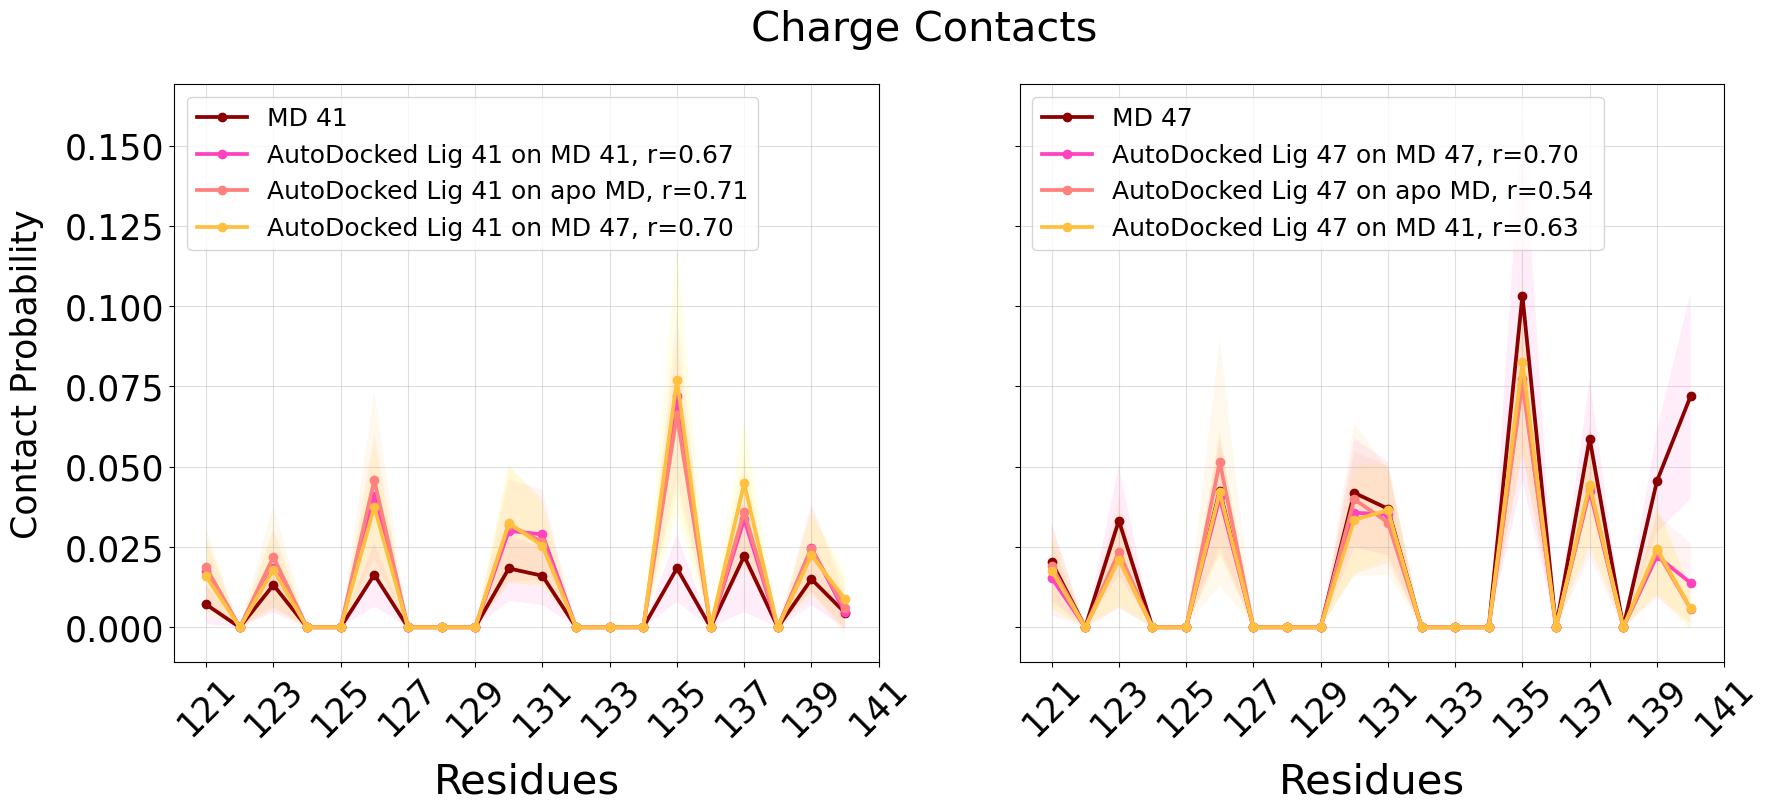

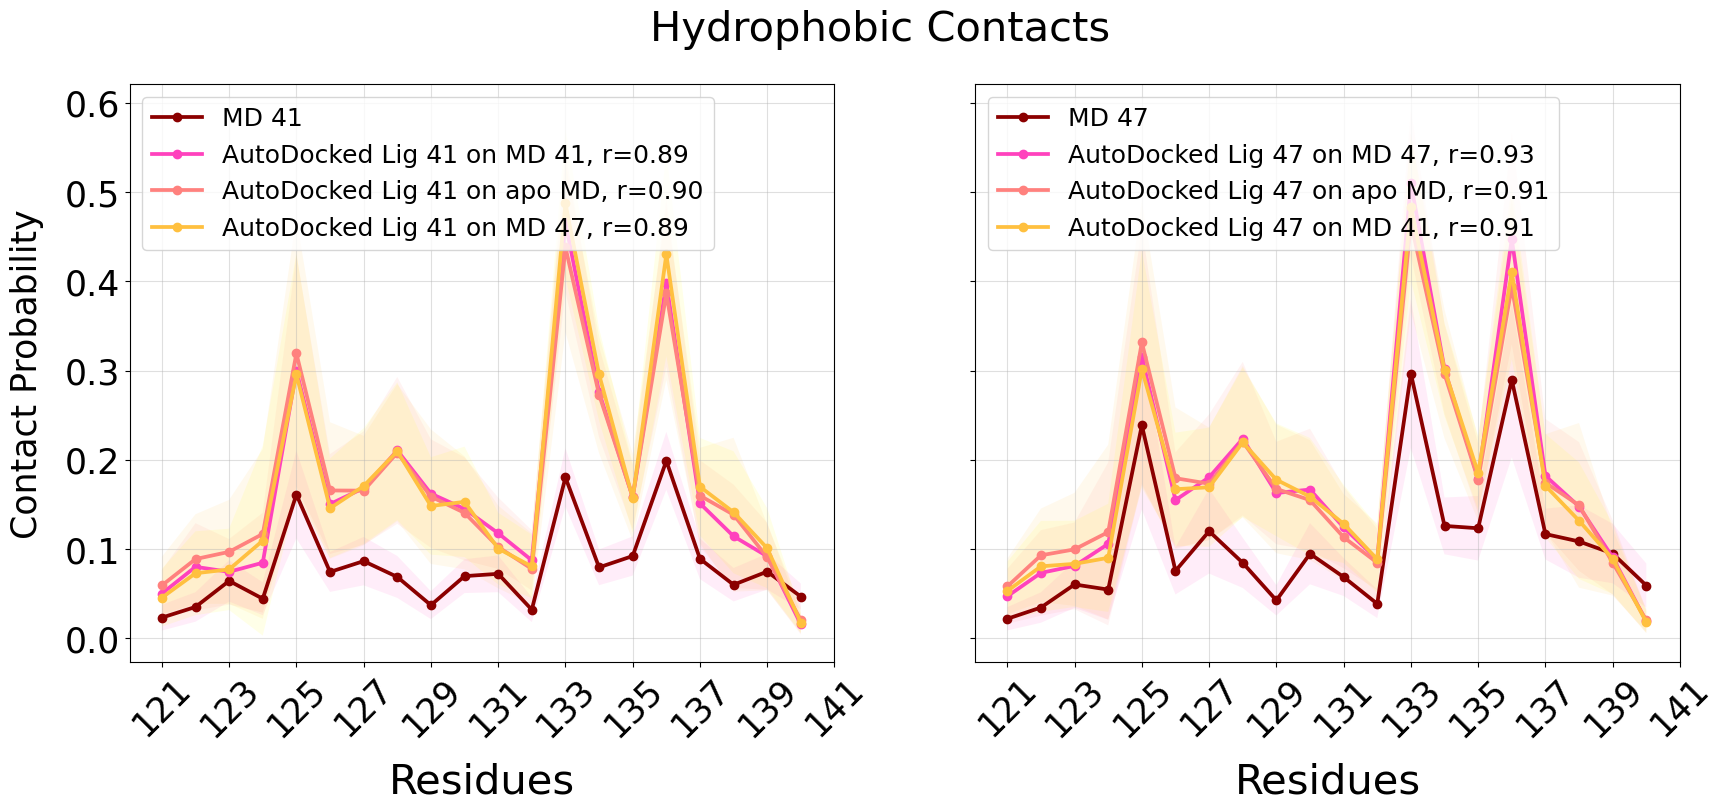

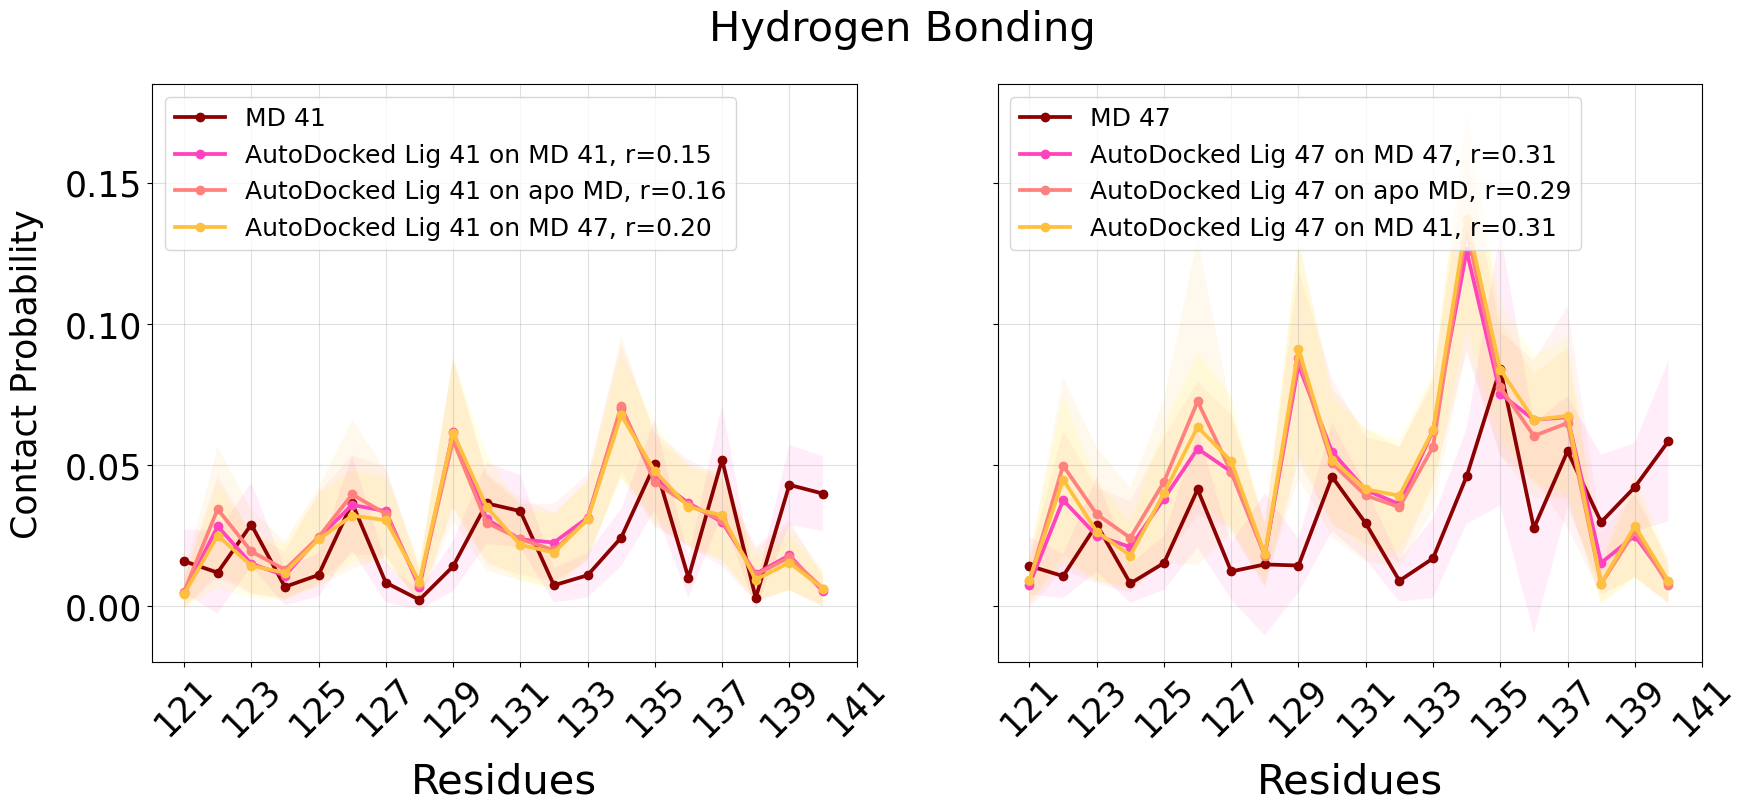

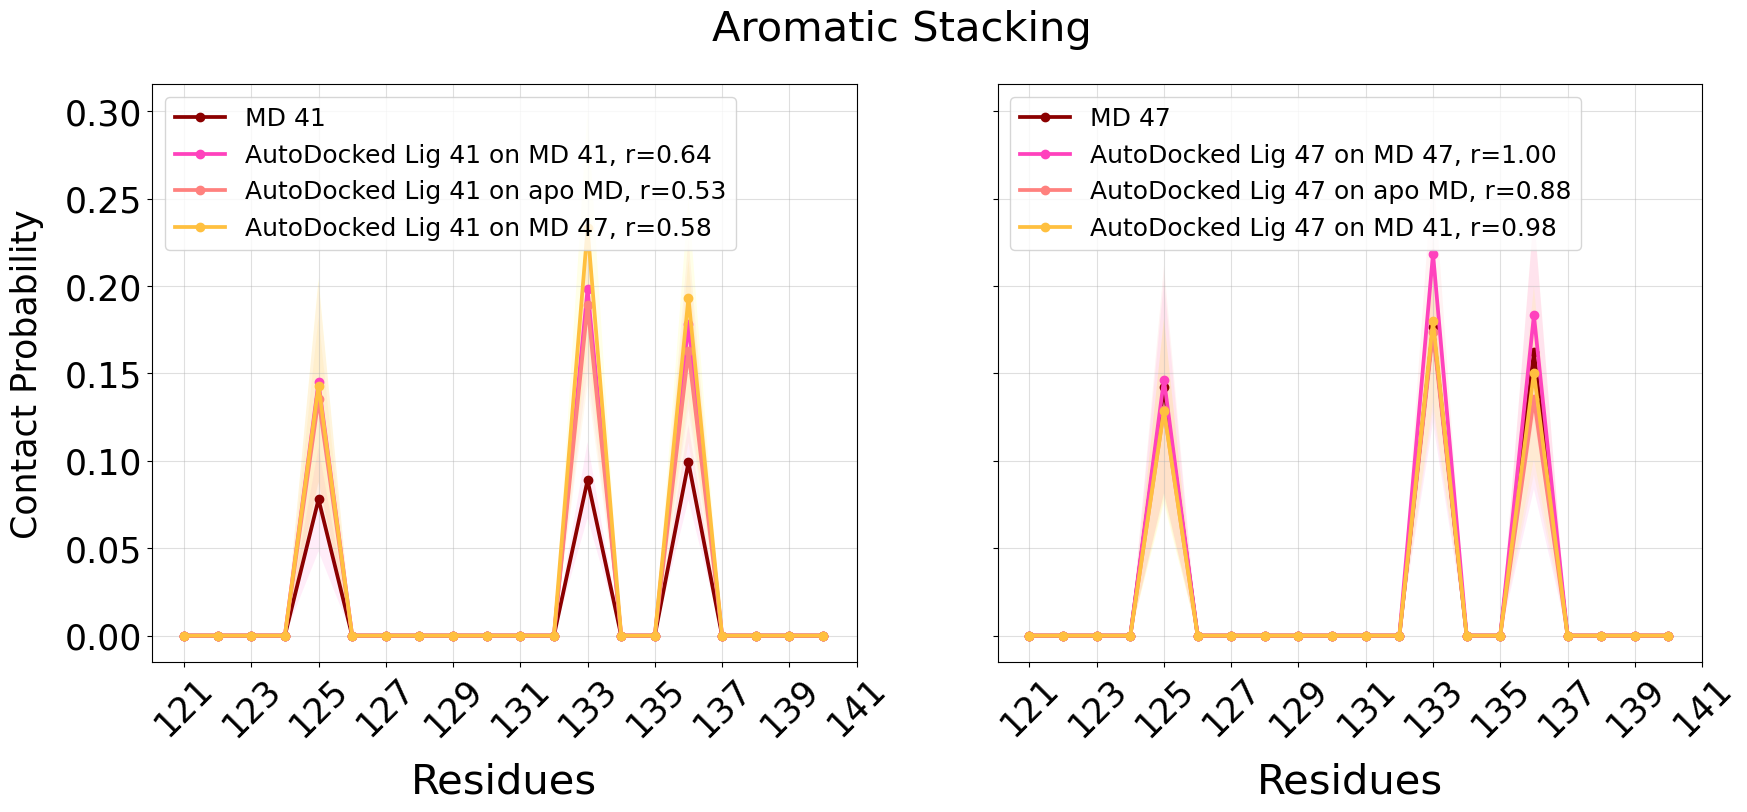

In [33]:
color_list = get_color_list(4, "spring", pre_trunc=65, trunc=0)
graph_runs = [['MD41', 'AD41on41bf', 'AD41onapo', 'AD41on47'], 
             ['MD47', 'AD47on47bf', 'AD47onapo', 'AD47on41']]
run_labels = [['MD 41', 'AutoDocked Lig 41 on MD 41', 
              'AutoDocked Lig 41 on apo MD', 'AutoDocked Lig 41 on MD 47'], 
              ['MD 47', 'AutoDocked Lig 47 on MD 47', 
              'AutoDocked Lig 47 on apo MD', 'AutoDocked Lig 47 on MD 41']]
graph_labels = ['Charge Contacts', 'Hydrophobic Contacts', 'Hydrogen Bonding', 
                'Aromatic Stacking']
ctypes = ['charge', 'hphob', 'hbond', 'aro']

for ctype, label in zip(ctypes, graph_labels): 
    graph_onlytype(graph_runs, run_labels, ctype, label, residues, color_list)


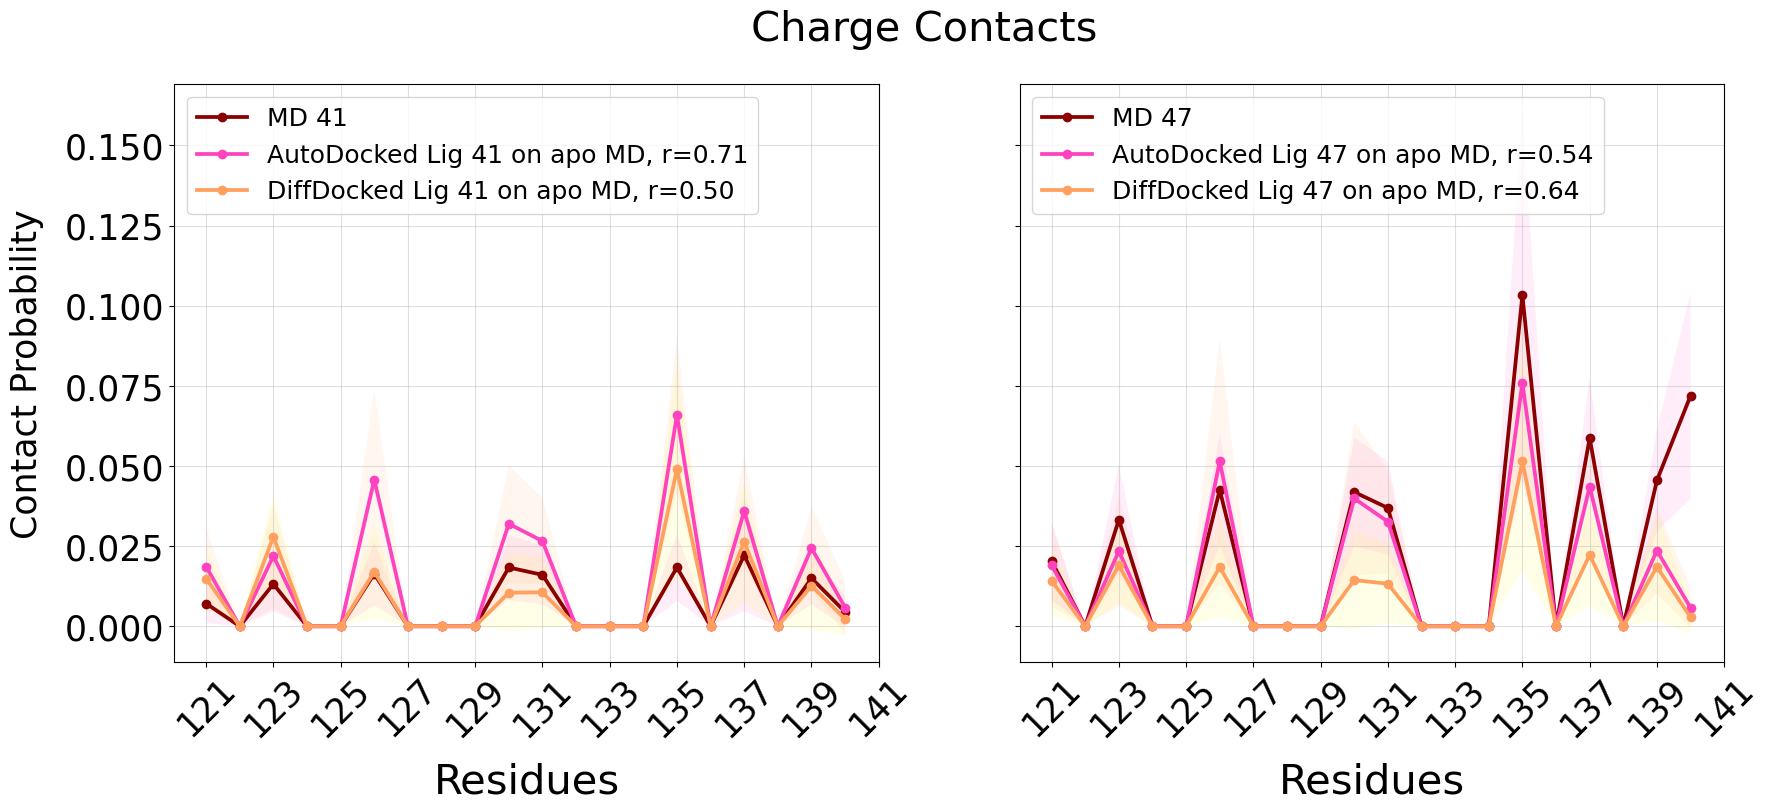

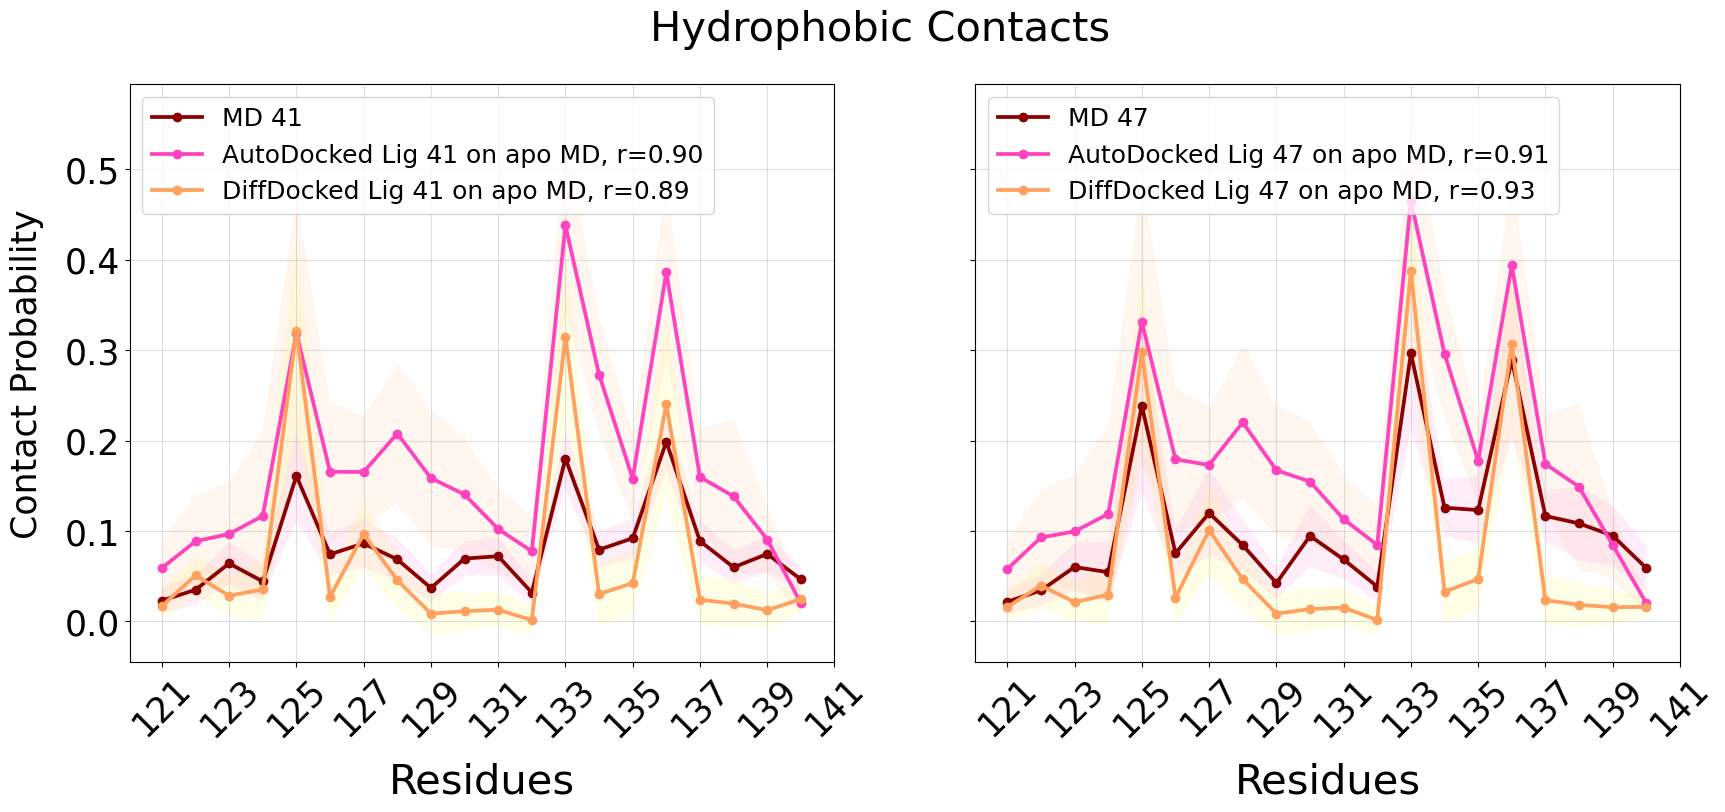

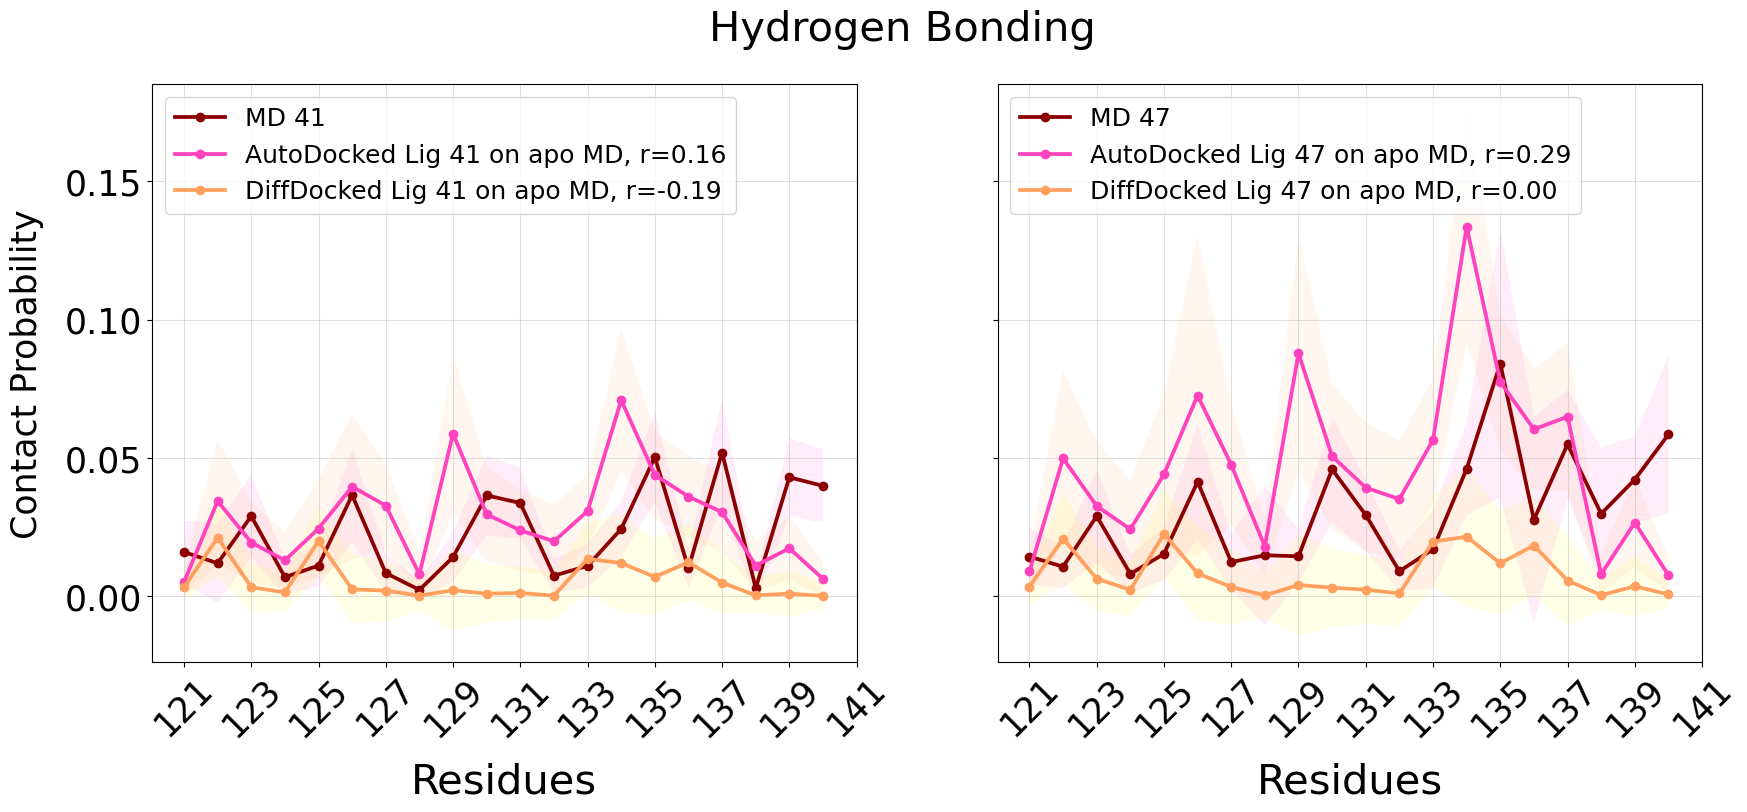

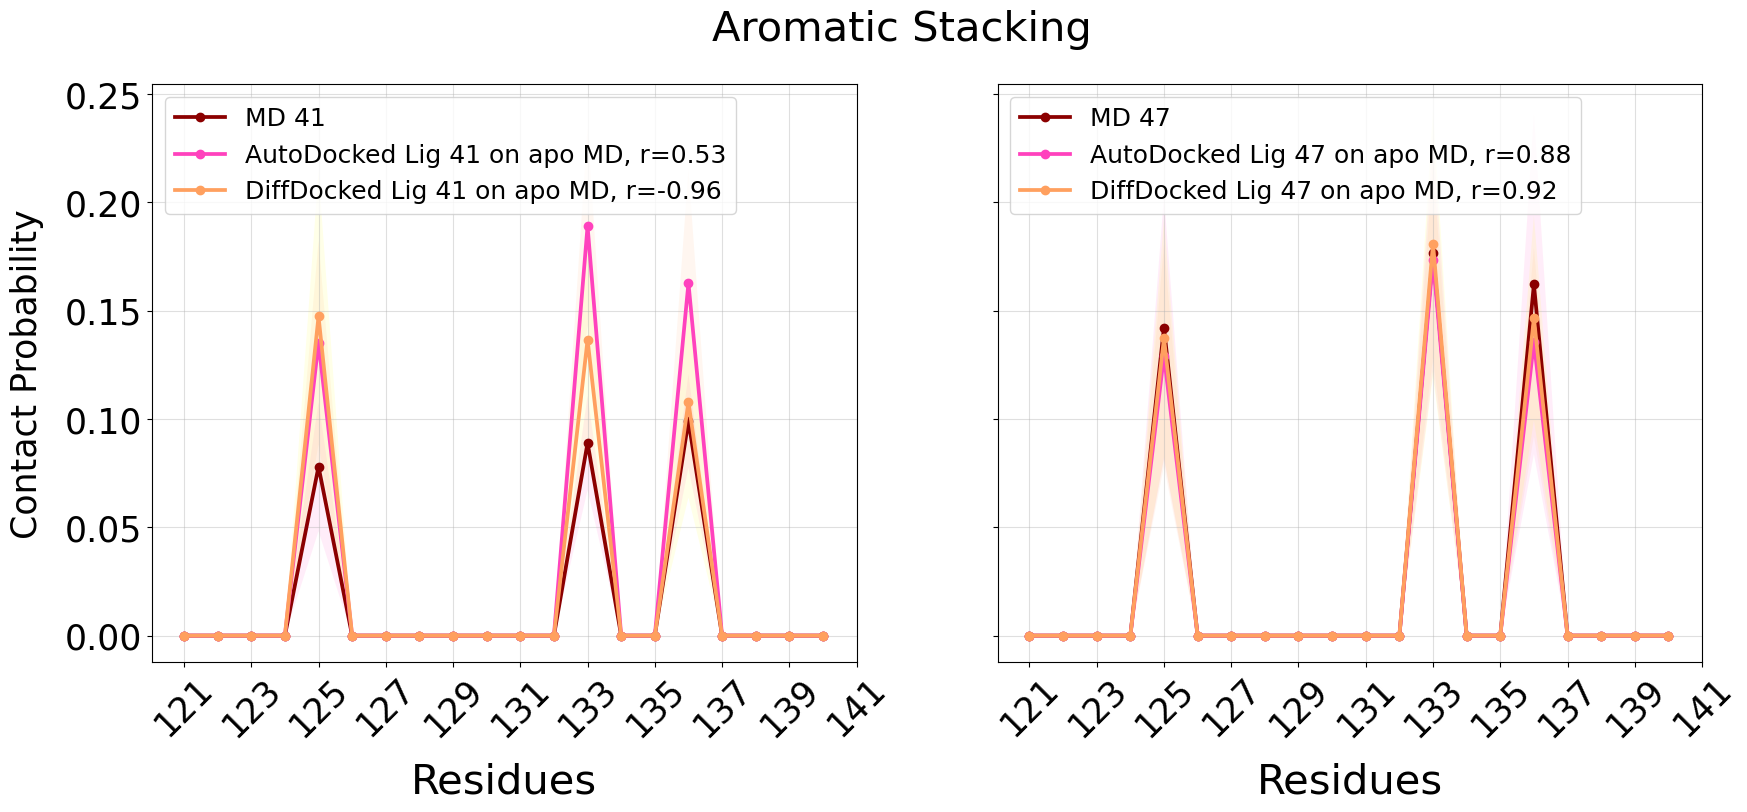

In [40]:
color_list = get_color_list(3, "spring", pre_trunc=65, trunc=0)
graph_runs = [['MD41', 'AD41onapo', 'DD41onapo'], 
             ['MD47', 'AD47onapo', 'DD47onapo']]
run_labels = [['MD 41', 'AutoDocked Lig 41 on apo MD', 
              'DiffDocked Lig 41 on apo MD'], 
              ['MD 47', 'AutoDocked Lig 47 on apo MD', 
              'DiffDocked Lig 47 on apo MD']]
graph_labels = ['Charge Contacts', 'Hydrophobic Contacts', 'Hydrogen Bonding', 
                'Aromatic Stacking']
ctypes = ['charge', 'hphob', 'hbond', 'aro']

for ctype, label in zip(ctypes, graph_labels): 
    graph_onlytype(graph_runs, run_labels, ctype, label, residues, color_list)
